<a href="https://colab.research.google.com/github/ablet-imin/ml-met-trigger/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings 
#warnings.filterwarnings('ignore')
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import h5py
import cell_data
import glob

files = list(glob.glob("data/ttbar/train-*.h5"))
print(isinstance(files, list))
cells_et, cells_ex, cells_ey, label = cell_data.get_data(files,
                                                         labelkey="MET_Calo_pt")
cells_ey = cells_ey.reshape(-1, cells_ey.shape[1]*cells_ey.shape[2])
x_train, x_test, y_train, y_test = train_test_split(cells_ey, label,
                                                test_size=0.2, random_state=42,
                                                shuffle=True
                                                )


True


In [66]:
#Linear regression
lr_models = {
    #'xgr' : XGBRegressor(),
    #'lgb' : LGBMRegressor(),
    'lr': LinearRegression(),
    #'rfr': RandomForestRegressor(),
    'kr' : KNeighborsRegressor(),
    #'svr': SVR(kernel='linear'),
    'dtr': DecisionTreeRegressor()
}
nModels = len(lr_models.keys())
scores = pd.DataFrame(index=lr_models.keys(),
                      columns=['train', 'test', 'test_r2'],
                      data=np.zeros((nModels,3)) )
met_pred = {}
def fit_to_data():
    for name, lr in lr_models.items():
        lr.fit(x_train, y_train)
        scores['train'][name] = lr.score(x_train,y_train)
        scores['test'][name] = lr.score(x_test,y_test)
        predicted = lr.predict(x_test)
        scores['test_r2'][name] = r2_score(y_test, predicted,)
        #scores['test_RMS'][name] = mean_squared_error(y_test, predicted, squared=False)
        met_pred[name] = predicted
        print(f'{name:10}OK')

In [67]:
fit_to_data()

lr        OK
kr        OK
dtr       OK


In [68]:
#upload results to wandb
#!pip install wandb

In [69]:
import wandb
wandb.login(key="bbfdeb3824dbf84bd7fc4fa55c5737dab40a8cb7")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [70]:

run = wandb.init(project="Regression-linear-ey")


In [71]:
wandb.log({
    'scores': scores
})

met_pred['truth']=y_test

wandb.log({
    'prediction': pd.DataFrame(met_pred)
})


In [72]:
xs=scores.index.to_list()
ys=[scores[sk].to_list() for sk in scores.columns.to_list()]

wandb.log({"Score_lines" : wandb.plot.line_series(
          xs=range(len(xs)),
          ys=ys,
          keys=scores.columns.to_list(),
          title="scors",
          xname="x units")})

In [73]:
bins = np.linspace(-100, 400, 51)
for key in met_pred.keys(): 
    _hist = np.histogram(met_pred[key], bins)
    wandb.log({key: wandb.Histogram(np_histogram=_hist)})

## plot Et

In [74]:
#for plot with ATLAS styple
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import mplhep as hep
#hep.style.use(hep.style.ROOT) # For now ROOT defaults to CMS
# Or choose one of the experiment styles
hep.style.use(hep.style.ATLAS)
plt.style.use(hep.style.ATLAS)

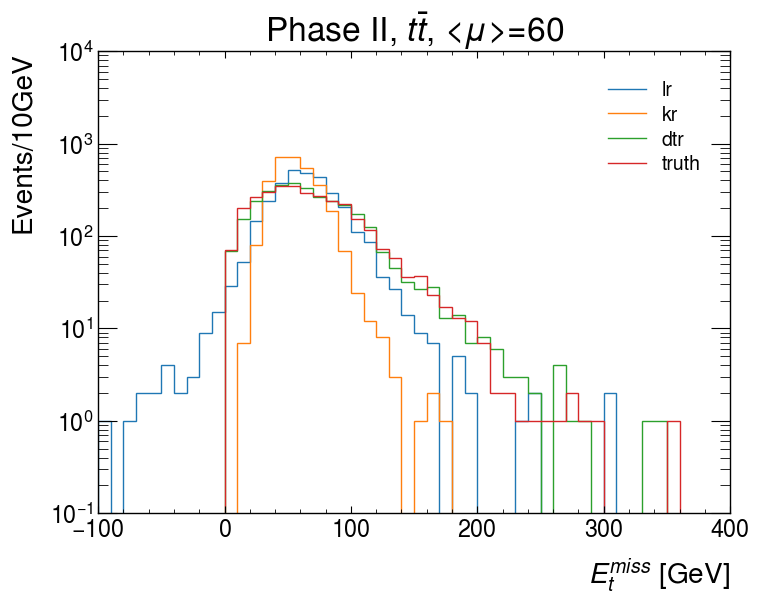

In [75]:
#bin all predicted METs
bins = np.linspace(-100, 400, 51)
fig, axs = plt.subplots()
def get_h(key):
    h, _ = np.histogram(met_pred[key], bins)
    return h
    
hep.histplot([get_h(key) for key in met_pred.keys()],bins,
             ax=axs, label=[key for key in met_pred.keys()] )
axs.legend()
axs.set_xlabel(r"$E_{t}^{miss}$ [GeV]")
axs.set_ylabel(r"Events/10GeV")
axs.set_yscale('log')
axs.set_title(r"Phase II, $t \bar t$, <$\mu$>=60")

wandb.log({"final_plot_log":wandb.Image(plt)})

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x155f18700>, cbar=<matplotlib.colorbar.Colorbar object at 0x155f18400>, text=[])

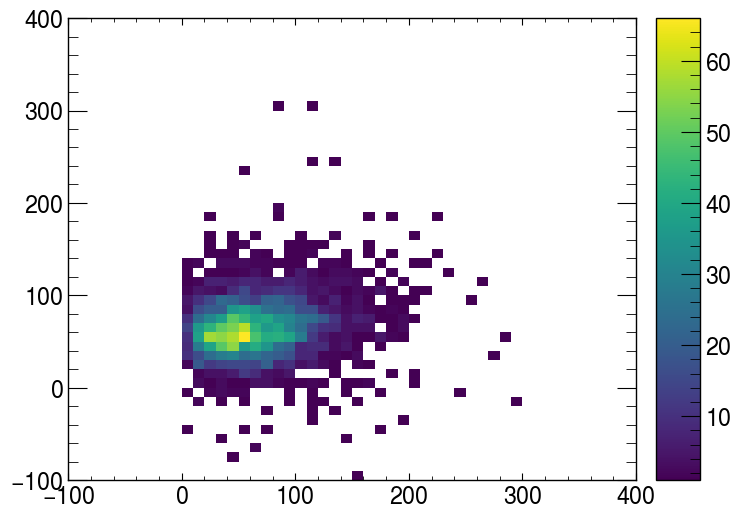

In [76]:
fig2D, axs2D = plt.subplots()
H, xedges, yedges = np.histogram2d(met_pred['truth'], met_pred['lr'], bins=(bins, bins))
H[H==0]=np.NaN
hep.hist2dplot(H, xedges, yedges)


In [77]:
scores

,train,test,test_r2
lr,0.421272,-0.373086,-0.373086
kr,0.333632,-0.038544,-0.038544
dtr,1.000000,-0.796188,-0.796188
